# Single transit search

In this notebook, we use `nuance` to search for a single transit. Let's generate some data first, of a unique planetary transit lost in a smooth stellar variability signal

/Users/lgrcia/code/dev/nuance/nuance/nuance.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


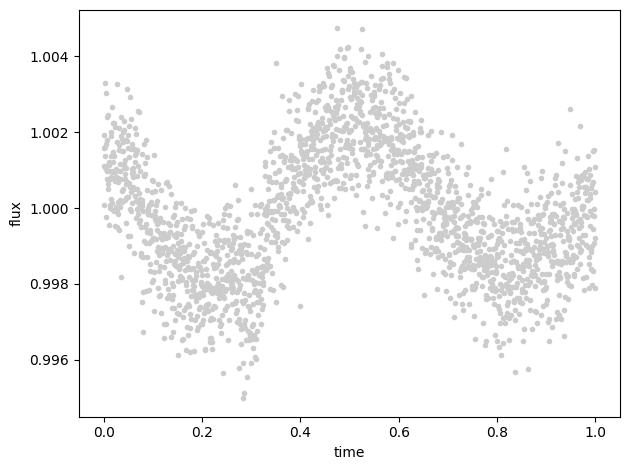

In [1]:
import matplotlib.pyplot as plt
from nuance import utils
import numpy as np

t = np.linspace(0, 1, 2000)
true = {"t0": 0.3, "D": 0.05, "P": 10, "depth": 1e-3}
(time, flux, error), X, gp = utils.simulated(t=t, **true)
plt.plot(time, flux, ".", c="0.8")
plt.ylabel("flux")
plt.xlabel("time")

plt.tight_layout()

## The *linear search*

We start by instantiating a [Nuance](nuance.Nuance) object, and perform the *linear search* over all times (considered as potential transit epochs) and on a wide range of durations.

In [2]:
from nuance import Nuance, utils

nu = Nuance(time, flux, gp=gp, X=X)

t0s = time.copy()
Ds = np.linspace(0.01, 0.2, 15)
nu.linear_search(t0s, Ds)


  0%|          | 0/200 [00:00<?, ?it/s]

To have an idea of where the potential candidates might be, let's plot the unique transit log-likelihood computed during the linear search.

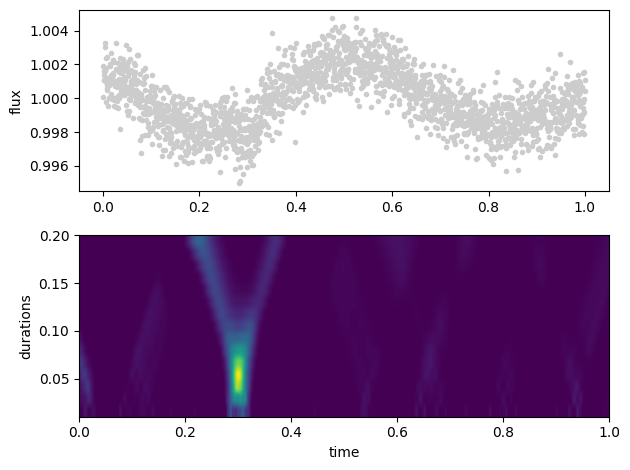

In [3]:
plt.subplot(211)
plt.plot(time, flux, ".", c="0.8")
plt.ylabel("flux")

plt.subplot(212)
nu.search_data.show_ll()
plt.ylabel("durations")
plt.xlabel("time")

plt.tight_layout()


We clearly identify a transit candidate, that we can plot thanks to its parameters

In [4]:
t0, D, _ = nu.search_data.best
linear, astro, noise = nu.models(t0, D)
plt.plot(time, flux, ".", c="0.8")
plt.plot(time, linear + astro + noise, c="k", label="full model")
plt.plot(
    time,
    true["depth"] * utils.periodic_transit(t, D=true["D"], t0=true["t0"]) + 1.0,
    ls="-",
    c="C0",
    label="injected",
)
plt.plot(time, astro + 1.0, ls="--", c="k", label="found")
plt.legend()
plt.ylabel("flux")
plt.xlabel("time")

plt.tight_layout()
print("\n".join([f"{n}: {v:.3f}" for n, v in zip(["epoch", "duration"], [t0, D])]))

AssertionError: No search performed

Which is the one injected in the simulated dataset